Резников Никита Вячеславович; ТФэ-01-21; @reznya_tv

По аналогии с решением задач из практики, построить график зависимости $\eta_{oi} = f(H_0)$ в диапазоне $H_0$ = (50 - 150) $\frac {kJ}{kg}$. $\eta_{ол}$ = 78%. $u = 160 m/s$. Все остальные переменные и условия принять такие же как на практическом заняти.

In [25]:
MPa = 10**6

In [26]:
p = 5 * MPa
t = 489+273
H_0 = range(50,150)
u = 160
d_r = 1.09
s_div_r = 0.2
degree__of_reaction = 0.1
z_bandage = 2
delta_r_bandage = 1.17 / 1000
delta_a_bandage = 4 / 1000
z_rotor = 5
d_leak_rotor = 0.36
delta_leak_rotor = 0.4 / 1000
e = 0.8
sin_alpha_1 = 0.225
blade_width = 0.035
blade_length = 0.035
blade_efficiency = 0.78
segments = 4
F1 = 0.025
K_y = 1
mu_r_rotor = 0.8
mu_r = mu_r_rotor
mu_a = 0.5
mu_nozzle = 0.97

In [27]:
import iapws
from iapws import IAPWS97 as gas
import math
import matplotlib.pyplot as plt
import numpy as np
MPa = 10 ** 6
kPa = 10 ** 3
unit = 1 / MPa
to_kelvin = lambda x: x + 273.15 if x else None

In [28]:
point = gas(P=p * unit, T=t)
kinematic_viscosity = point.nu

In [29]:
def get_Re_numbeer(u, d_r):
        return  u * d_r * 0.5 / kinematic_viscosity

In [30]:
def get_k_frictions(s_div_r, re):
        return 2.5 * 10 ** (-2) * s_div_r ** 0.1 * re **(-0.2)

In [31]:
def get_friction_loss_pu(s_div_r, d_r, u, kinematic_viscosity, u_div_dummy_speed, F1):
    Re_number = get_Re_numbeer(u,d_r)
    k = get_k_frictions(s_div_r, Re_number)
    friction_loss_pu = k * d_r ** 2 * u_div_dummy_speed ** 3 / F1 
    return friction_loss_pu

In [32]:
def get_ventilation_loss_pu(m, k, sin, e, u_div_dummy_speed):
    first = k / sin
    second = (1 - e) / e
    third = u_div_dummy_speed ** 3
    return first * second * third * m

In [33]:
def get_segment_loss_pu(B, l, F, u_div_dummy_speed, blade_efficiency, segments):
    first = 0.25 * B * l / F
    second = u_div_dummy_speed * blade_efficiency * segments
    return first * second

In [34]:
def get_partial_losses_pu(u_div_dummy_speed, blade_width, blade_length, F1, blade_efficiency, segments):
    ventilation_loss_pu = get_ventilation_loss_pu(
    m = 1,
    k = 0.065,
    e = e,
    u_div_dummy_speed = u_div_dummy_speed,
    sin = sin_alpha_1
    )
    segment_loss_pu = get_segment_loss_pu(
    B = blade_width,
    l = blade_length,
    F = F1,
    u_div_dummy_speed = u_div_dummy_speed,
    blade_efficiency = blade_efficiency,
    segments = segments
    )
    partial_losses_pu = segment_loss_pu + ventilation_loss_pu
    return partial_losses_pu

In [35]:
def compute_equal_gap(z, delta_r, mu_r_rotor, delta_a, mu_a):
    first = 1 / (mu_a * delta_a) ** 2
    second = z / (mu_r_rotor * delta_r) ** 2
    return (first + second) ** (-0.5)

In [36]:
def get_bandage_leak_loss_pu(d_shroud, delta_eq, F, dor, l, efficiency):
    d_avg = d_shroud - l
    first = math.pi * d_shroud * delta_eq / F
    second = dor + 1.8 * (l / d_avg)
    return first * (second) ** 0.5 * efficiency

In [37]:
def get_disk_leak_loss_pu(K, F, mu_r_rotor, mu_nozzle, F_nozzle, z, efficiency):
    upper = mu_r_rotor * K * F * efficiency
    lower = mu_nozzle * F_nozzle * z ** 0.5
    return upper / lower

In [38]:
def get_leak_losses_pu(z_bandage, delta_r_bandage, mu_r_rotor, delta_a_bandage, z_rotor, mu_a, mu_nozzle, F1, degree__of_reaction, blade_length, delta_leak_rotor, d_leak_rotor, blade_efficiency, K_y):
    d_shroud = delta_r_bandage / 0.001 
    delta_eq_bandage = compute_equal_gap(
        z = z_bandage,
        delta_r = delta_r_bandage,
        mu_r_rotor = mu_r_rotor,
        delta_a = delta_a_bandage,
        mu_a = mu_a
    )
    bandage_leak_loss_pu = get_bandage_leak_loss_pu(
        d_shroud = d_shroud,
        delta_eq = delta_eq_bandage,
        F = F1,
        dor = degree__of_reaction,
        l = blade_length,
        efficiency = blade_efficiency
        )
    F_leak_rotor = math.pi * d_leak_rotor * delta_leak_rotor
    disk_leak_loss_pu = get_disk_leak_loss_pu(
        K = K_y,
        F = F_leak_rotor,
        mu_r_rotor = mu_r_rotor,
        mu_nozzle = mu_nozzle,
        F_nozzle = F1,
        z = z_rotor,
        efficiency = blade_efficiency
    )
    leak_losses_pu = disk_leak_loss_pu + bandage_leak_loss_pu
    return leak_losses_pu

In [39]:
def get_internal_efficiency(blade_efficiency, friction_loss_pu, partial_losses_pu, leak_losses_pu):
    internal_efficiency = blade_efficiency - friction_loss_pu - partial_losses_pu - leak_losses_pu
    return internal_efficiency

In [40]:
leak_losses_pu = get_leak_losses_pu(
    z_bandage = z_bandage,
    delta_r_bandage = delta_r_bandage,
    mu_r_rotor = mu_r_rotor,
    delta_a_bandage = delta_a_bandage,
    z_rotor = z_rotor,
    mu_a = mu_a,
    mu_nozzle = mu_nozzle,
    F1 = F1,
    degree__of_reaction = degree__of_reaction,
    blade_length = blade_length,
    delta_leak_rotor = delta_leak_rotor,
    d_leak_rotor  = d_leak_rotor,
    blade_efficiency = blade_efficiency,
    K_y = K_y
)

In [41]:
internal_efficiency = []
for H_0value in H_0:
    H_0value=H_0value*1000
    dummy_speed = (2 * H_0value) ** 0.5
    u_div_dummy_speed = u / dummy_speed
    friction_loss_pu = get_friction_loss_pu(
        s_div_r = s_div_r,
        d_r = d_r, 
        u = u,
        kinematic_viscosity = kinematic_viscosity,
        u_div_dummy_speed = u_div_dummy_speed,
        F1 = F1
    )
    partial_losses_pu = get_partial_losses_pu(
        u_div_dummy_speed = u_div_dummy_speed,
        blade_width = blade_width,
        blade_length = blade_length,
        F1 = F1,
        blade_efficiency = blade_efficiency,
        segments = segments
    )
    internal_efficiency.append(get_internal_efficiency(blade_efficiency,friction_loss_pu,partial_losses_pu,leak_losses_pu))

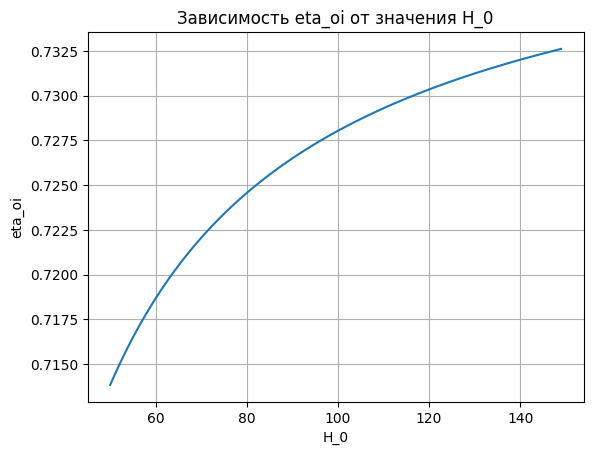

In [42]:
plt.plot(H_0,internal_efficiency)  
plt.xlabel("H_0")
plt.ylabel('eta_oi')
plt.title("Зависимость eta_oi от значения H_0")
plt.grid()